In [1257]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import gensim
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel

import matplotlib.pyplot as plt
%matplotlib inline

# In this notebook, we do the following:
1. Get word vectors of words appearing in title / synopsis.
2. Get TF-IDF representation of words.
3. Use TF-IDF as weight to get the sentence vector from the word vectors.
4. Get cosine similarity of sentence vectors with each dimension.
5. Use embedding model to calculate the frequency of word ranks in the title and synopsis.
6. Look at correlation between similarity to dimensions and gross performance.
7. Use cosine similarities and word rank frequencies as features of a classification model (instead of a regression model).

# Load NF dimensions and embedding model

In [156]:
dimensions = pd.read_csv('data/dimensions.csv', usecols = ['en_label', 'en'])

In [157]:
# remove brand-specific labels
dimensions = dimensions.iloc[:200]

In [158]:
# remove rows with no words
dimensions = dimensions[~dimensions['en'].isnull()]

In [159]:
# turn to lowercase
dimensions['en_label'] = dimensions['en_label'].str.lower()
dimensions['en'] = dimensions['en'].str.lower()

In [160]:
# tokenize words
dimensions['tokenized'] = dimensions['en'].str.replace('-', '_').str.replace(',', ' ').map(word_tokenize)

In [28]:
# load embedding model
emb = gensim.models.KeyedVectors.load_word2vec_format('data/en_en_numberbatch_v1706.bin', binary=True)

In [1130]:
def get_average_vector(words):
    """
        Average the word vectors of a list of words.
    """
    words_in_emb = [emb[word] for word in words if word in emb.vocab.keys()]
    total = np.sum(words_in_emb, axis=0)
    count = len(words_in_emb)
    return total / count

In [162]:
dimensions['dimension'] = dimensions['tokenized'].map(get_dimension)
dimensions = dimensions.drop(columns=['en'])

In [1270]:
dimensions = dimensions.reset_index().drop(columns='index')

In [313]:
# get word ranks from embedding model
word_rank = pd.Series(list(emb.vocab.keys())).reset_index()

In [314]:
# divide word ranks into deciles
word_rank['percentile'] = pd.qcut(word_rank['index'], 10, labels = ['<10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90+'])

In [325]:
rank_dict = dict(zip(word_rank[0].values, word_rank['percentile'].values))

In [335]:
rank_labels = word_rank['percentile'].unique()

# Load data from last week and remove blockbusters

In [205]:
# load data from the last notebook
pc = pd.read_csv('data/wiki_matched.csv')

In [863]:
pc.head()

,year,rank,movie_title,rating,genre1,genre2,runtime,distributor,budget,adjusted_opening,...,wiki_wv_290.1.1,wiki_wv_291.1.1,wiki_wv_292.1.1,wiki_wv_293.1.1,wiki_wv_294.1.1,wiki_wv_295.1.1,wiki_wv_296.1.1,wiki_wv_297.1.1,wiki_wv_298.1.1,wiki_wv_299.1.1
0,2010,1,Toy Story 3,G,Animation,NaN,103.0,Buena Vista,200000000.0,128225100.0,...,-50.865868,32.915565,-58.361187,4.377266,-32.066540,-25.931126,5.769211,-3.233112,28.904930,-16.628872
1,2010,2,Alice in Wonderland,PG,Family,Adventure,109.0,Buena Vista,200000000.0,133771700.0,...,-41.149185,-5.958760,-62.160366,1.402843,-32.683230,-16.236320,8.561918,-7.410161,29.774704,1.001106
2,2010,3,Iron Man 2,PG-13,Action,Adventure,125.0,Paramount,200000000.0,148934300.0,...,-39.669506,-14.324506,-59.775740,10.558628,-26.508518,-28.648207,-0.950573,-18.508064,18.950455,2.602741
3,2010,4,The Twilight Saga: Eclipse,PG-13,Romance,NaN,124.0,Summit Entertainment,68000000.0,75363300.0,...,-51.736317,0.388475,-69.993520,3.962325,-46.181377,0.863689,21.058079,-11.719788,45.462060,11.379520
4,2010,5,Inception,PG-13,Sci-Fi,Action,148.0,Warner Bros.,160000000.0,74593200.0,...,-66.710880,26.594257,-71.274460,19.334301,-56.281460,-8.980194,-9.290649,-19.509369,35.494690,-0.012482


In [206]:
pc['tokenized_words'] = pc['movie_title'].str.lower().str.replace(r'[^a-zA-Z0-9 ]', '').str.replace(r'\'', '').map(word_tokenize)
pc['wiki_tokenized_words'] = pc['wiki_synopsis'].str.replace(r'[^a-zA-Z0-9 ]', '').str.replace(r'\'', '').map(word_tokenize)

In [864]:
# only retain genre, total gross per cinema, and text features
reduced = pc[['movie_title', 'genre1', 'adjusted_total_gross_per_cinema', 'tokenized_words', 'wiki_tokenized_words']]

In [262]:
# get average word vectors assuming all words in the title/synopsis have equal weight
reduced['wv_title'] = reduced['tokenized_words'].map(get_average_vector)
reduced['wv_synopsis'] = reduced['wiki_tokenized_words'].map(get_average_vector)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [263]:
def cosine_similarity(a,b):
    """
        Compute the cosine similarity of a and b.
    """
    return np.dot(a,b) / ( (np.dot(a,a) **.5) * (np.dot(b,b) ** .5) )

In [783]:
def get_similarity_with_dimensions(row, inp, dimensions, tfidf = False):
    """
        Get similarity of row's word vector and every dimension.
        row : row of the movie dataframe
        inp : either 'title' or 'synopsis'
        dimensions : dataframe containing Neuroflash dimensions
        tfidf : true if we are using TFIDF-weighted sentence vectors
    """
    for k in range(dimensions['dimension'].shape[0]):
        if tfidf:
            wv = 'wv_' + inp + '_tfidf'
            name = 'cos_' + inp + '_dim_' + str(k) + '_tfidf'
        else: 
            wv = 'wv_' + inp
            name = 'cos_' + inp + '_dim_' + str(k)  
        # define a new column for the cosine similarity of dimension k and inp
        row[name] = cosine_similarity(row[wv], dimensions['dimension'].iloc[k])
    return row

In [291]:
# retain only rows with filled-up title and synopis
reduced = reduced[~reduced['wv_title'].isnull()]
reduced = reduced[~reduced['wv_synopsis'].isnull()]

In [293]:
reduced = reduced.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions), axis=1)

KeyboardInterrupt: 

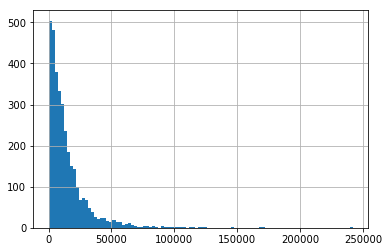

In [883]:
reduced['adjusted_total_gross_per_cinema'].hist(bins = 100);

In [ ]:
reduced['adjusted_total_gross_per_cinema'].hist

As suggested in the last meeting, we remove blockbusters from our analysis. Arbitrarily set movies with > 50000 USD to be blockbusters.

In [ ]:
no_blockbuster = reduced[reduced['adjusted_total_gross_per_cinema'] < 50000]

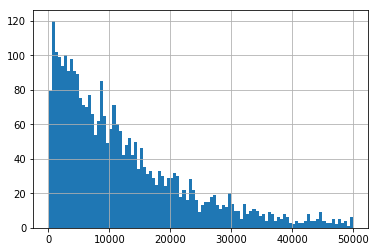

In [872]:
no_blockbuster['adjusted_total_gross_per_cinema'].hist(bins = 100);

# Correlations with Adjusted Total Gross per Cinema
In this part, we look at the correlation of each TFIDF-weighted title/synopsis vector and word rank frequency with the adjusted total gross per cinema.

In [1122]:
def get_tfidf_wv(row, emb, d, col = 'wiki_tokenized_words'):
    """
        Get TFIDF-weighted vector for either title or synopsis.
        row : row of movie dataframe
        emb : embedding model used
        d : Gensim dictionary for the corpus
        col : either 'wiki_tokenized_words' (synopsis) or 'tokenized_words' (title)
    """
    if col == 'wiki_tokenized_words':
        tfidf_map = row['wiki_tfidf_map']
        name = 'wv_synopsis'
    else:
        tfidf_map = row['tfidf_map']
        name = 'wv_title'
    words = row[col]
    total = np.zeros(300)
    for word in words:
        if (word in d.token2id.keys() and d.token2id[word] in tfidf_map.keys() and word in emb.vocab.keys()):
            # use the TFIDF of word as the weight to the word vector of word
            total += np.array(tfidf_map[d.token2id[word]] * emb[word])
    count = len(result)
    if count == 0:
        row[name + '_tfidf'] = np.nan
    else:
        row[name + '_tfidf'] = total / count
    return row

In [367]:
def get_word_rank_count(row, inp, rank_dict, rank_labels):
    """
        Get the frequency of the word rank deciles <10 to 90+
        row : row of movie dataframe
        inp : either 'title' or 'synopsis'
        rank_dict : dictionary from words to ranks
        rank_labels : labels for the word rank deciles
    """
    if inp == 'title':
        val = 'tokenized_words'
    elif inp == 'synopsis':
        val = 'wiki_tokenized_words'
    else:
        return
    word_count = len(row[val])
    running = 0
    for k in range(10):
        # count the number of words belonging to decile k
        total = np.sum([1 for y in [rank_dict[x] for x in row[val] if x in rank_dict.keys()] if y == rank_labels[k]]) 
        # divide by the total number of words to get frequency
        freq = total / word_count
        row['freq_' + inp + '_'+ rank_labels[k]] = freq
        running += freq
    row['freq_' + inp + '_notinemb'] = 1 - running
    return row

In [1133]:
no_blockbuster = no_blockbuster.apply(lambda x: get_word_rank_count(x, 'title', rank_dict, rank_labels), axis=1)
no_blockbuster = no_blockbuster.apply(lambda x: get_word_rank_count(x, 'synopsis', rank_dict, rank_labels), axis=1)

In [734]:
dict_synopsis = Dictionary(no_blockbuster['wiki_tokenized_words'].values)
dict_title = Dictionary(no_blockbuster['tokenized_words'].values)

In [735]:
corpus_synopsis = [dict_synopsis.doc2bow(line) for line in no_blockbuster['wiki_tokenized_words'].values]
corpus_title = [dict_title.doc2bow(line) for line in no_blockbuster['tokenized_words'].values]

In [736]:
model_synopsis = TfidfModel(corpus_synopsis, id2word=dict_synopsis) 
model_title = TfidfModel(corpus_title, id2word=dict_title) 

In [ ]:
no_blockbuster = no_blockbuster.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis, 'wiki_tokenized_words'), axis=1)
no_blockbuster = no_blockbuster.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)   

no_blockbuster = no_blockbuster.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=True), axis=1)
no_blockbuster = no_blockbuster.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=True), axis=1)    

In [1158]:
no_blockbuster[[x for x in no_blockbuster.columns if 'tfidf' in x or 'freq' in x] + ['adjusted_total_gross_per_cinema']].corr()['adjusted_total_gross_per_cinema'].sort_values()

cos_synopsis_dim_47_tfidf         -0.148469
cos_synopsis_dim_164_tfidf        -0.145230
cos_synopsis_dim_81_tfidf         -0.132536
cos_synopsis_dim_157_tfidf        -0.129402
cos_synopsis_dim_167_tfidf        -0.127977
cos_synopsis_dim_146_tfidf        -0.122766
cos_synopsis_dim_7_tfidf          -0.121919
cos_synopsis_dim_48_tfidf         -0.121208
cos_synopsis_dim_153_tfidf        -0.120866
cos_synopsis_dim_102_tfidf        -0.119816
cos_synopsis_dim_83_tfidf         -0.114920
cos_synopsis_dim_89_tfidf         -0.114272
cos_synopsis_dim_111_tfidf        -0.113051
cos_synopsis_dim_29_tfidf         -0.112940
cos_synopsis_dim_172_tfidf        -0.111549
cos_synopsis_dim_161_tfidf        -0.110709
cos_synopsis_dim_5_tfidf          -0.110563
cos_synopsis_dim_65_tfidf         -0.109918
cos_synopsis_dim_162_tfidf        -0.109459
cos_synopsis_dim_122_tfidf        -0.107510
cos_synopsis_dim_18_tfidf         -0.107125
cos_synopsis_dim_134_tfidf        -0.107090
cos_synopsis_dim_139_tfidf      

Top 5 Negatively correlated:
* Synopsis Dim 47: emotion_negative
* Synopsis Dim 164: the lover
* Synopsis Dim 81: kompliziert
* Synopsis Dim 157: unpleasant
* Synopsis Dim 167: we

Top 5 Positively correlated:
* Synopsis Dim 20 : breakfast items
* Title Dim 17 : blue collar
* Frequency 80-90
* Synopsis Dim 24 : cheese
* Synopsis Dim 59 : fish

## Classification Model
Objective: Build a simple logistic regression model that predicts adjusted total gross per cinema from similarity of titles/ synopses with Neuroflash dimensions as well as embedding work ranks.

We define three buckets: 0 for low-gross movies (below 15000 USD), 1 for mid-gross (15000-30000), 2 for high gross (above 30000)

In [549]:
no_blockbuster['gross_bracket'] = pd.cut(no_blockbuster['adjusted_total_gross_per_cinema'], [0, 15000, 30000, 50000], labels = [0, 1, 2])

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [550]:
no_blockbuster['gross_bracket'].value_counts()

0    2153
1     683
2     241
Name: gross_bracket, dtype: int64

In [1226]:
def split_dataset_for_genre_classification(pc, emb, genre = '', var = 'gross_bracket', tfidf = False, whole = False):
    """
        Split train and tests sets for the specific genre
        
        Input:
            pc : dataframe of features
            genre : genre to filter
            var : box office performance metric
            w2v : whether to include word2vec features
            whole: whether to train on whole dataset or not
        Output:
            X_train : input training set
            X_test : input test set
            y_train : output training set
            y_test : output test set
            column_names : list of feature names
    """
    
    # check whether genre is provided
    # if yes, filter pc by genre
    if genre == '':
        pc = pc
    else:
        pc = pc[pc['genre1'] == genre]
    
    # only retain rows with non-null performance metric
    pc = pc[~pc[var].isnull()]
    
    column_names = ['tokenized_words', 'wiki_tokenized_words', 'wv_title', 'wv_synopsis', var]
    X = pc[column_names]
    
    if whole:
        X_train = X
        y_train = pc[var]
    
    else:
        # split 50-25-25 train-validation-test split
        X_trainval, X_test, y_trainval, y_test = train_test_split(X,
                pc[var], test_size=0.25, stratify = pc[var], random_state=0)
        X_train, X_val, y_train, y_val = train_test_split(X,
                pc[var], test_size=1/3, stratify = pc[var], random_state=0)
        X_train = pd.DataFrame(X_train, columns=column_names)
        X_val = pd.DataFrame(X_val, columns=column_names)
        X_test = pd.DataFrame(X_test, columns=column_names)

    dict_synopsis = Dictionary(X_train['wiki_tokenized_words'].values)
    dict_title = Dictionary(X_train['tokenized_words'].values)

    corpus_synopsis_train = [dict_synopsis.doc2bow(line) for line in X_train['wiki_tokenized_words'].values]
    corpus_title_train = [dict_title.doc2bow(line) for line in X_train['tokenized_words'].values]

    model_synopsis = TfidfModel(corpus_synopsis_train, id2word=dict_synopsis) 
    model_title = TfidfModel(corpus_title_train, id2word=dict_title) 

    if tfidf:
        X_train['wiki_tfidf_map'] = corpus_synopsis_train
        X_train['tfidf_map'] = corpus_title_train
        X_train['wiki_tfidf_map'] = X_train['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
        X_train['tfidf_map'] = X_train['tfidf_map'].map(lambda x: dict(model_title[x]))
        X_train = X_train.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis, 'wiki_tokenized_words'), axis=1)
        X_train = X_train.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)   

    X_train = X_train.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
    X_train = X_train.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

    if tfidf:
        column_names = [x for x in X_train.columns if ((x.startswith('cos') and x.endswith('tfidf')))]
    else:
        column_names = [x for x in X_train.columns if (x.startswith('cos'))]

    X_train = pd.concat([X_train[column_names], no_blockbuster.loc[X_train.index,:][[x for x in pc.columns if 'freq' in x]]], axis=1)
    
    pad = X_train.mean()
    X_train = X_train.fillna(pad)
    
    if whole:
        return X_train, None, None, y_train, None, None

    else:
        
        corpus_synopsis_val = [dict_synopsis.doc2bow(line) for line in X_val['wiki_tokenized_words'].values]
        corpus_title_val = [dict_title.doc2bow(line) for line in X_val['tokenized_words'].values]

        corpus_synopsis_test = [dict_synopsis.doc2bow(line) for line in X_test['wiki_tokenized_words'].values]
        corpus_title_test = [dict_title.doc2bow(line) for line in X_test['tokenized_words'].values]

        if tfidf:
            X_val['wiki_tfidf_map'] = corpus_synopsis_val
            X_val['tfidf_map'] = corpus_title_val
            X_val['wiki_tfidf_map'] = X_val['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
            X_val['tfidf_map'] = X_val['tfidf_map'].map(lambda x: dict(model_title[x]))
            X_val = X_val.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis), axis=1)
            X_val = X_val.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)

        X_val = X_val.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
        X_val = X_val.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

        X_val = X_val.fillna(pad)

        X_val = pd.concat([X_val[column_names], no_blockbuster.loc[X_val.index,:][[x for x in pc.columns if 'freq' in x]]], axis=1)

        if tfidf:
            X_test['wiki_tfidf_map'] = corpus_synopsis_test
            X_test['tfidf_map'] = corpus_title_test
            X_test['wiki_tfidf_map'] = X_test['wiki_tfidf_map'].map(lambda x: dict(model_synopsis[x]))
            X_test['tfidf_map'] = X_test['tfidf_map'].map(lambda x: dict(model_title[x]))
            X_test = X_test.apply(lambda x: get_tfidf_wv(x, emb, dict_synopsis), axis=1)
            X_test = X_test.apply(lambda x: get_tfidf_wv(x, emb, dict_title, 'tokenized_words'), axis=1)

        X_test = X_test.apply(lambda x: get_similarity_with_dimensions(x, 'title', dimensions, tfidf=tfidf), axis=1)
        X_test = X_test.apply(lambda x: get_similarity_with_dimensions(x, 'synopsis', dimensions, tfidf=tfidf), axis=1)    

        X_test = X_test.fillna(pad)

        X_test = pd.concat([X_test[column_names], no_blockbuster.loc[X_test.index,:][[x for x in no_blockbuster.columns if 'freq' in x]]], axis=1)

        return X_train, X_val, X_test, y_train, y_val, y_test   

In [1251]:
def train_model(modeltype, X_train, y_train, C=1):
    """
        Train chosen model.
        
        Input:
            modeltype : 'lr'. I wrote this to be extendable easily.
            X_train : input training set
            y_train : output training set
        Output:
            model : trained linear regression model
    """

    if modeltype == 'lr':
        model = LogisticRegression(class_weight='balanced', C=C)
    model.fit(X_train, y_train)
    return model

In [1286]:
def evaluate_model(model, X, y):
    """
        Evaluate trained model.
        
        Input:
            X : input to model
            y : output to predict
    """
    
    print('accuracy : {}'.format(model.score(X, y)))
    print(classification_report(y, model.predict(X)))
    print(confusion_matrix(y, model.predict(X)))

In [1324]:
def plot_most_relevant_features(model, column_names, n=5):
    """
        Plot the features which have the highest effect on
        box office performance based on the mode.
        
        Input:
            model : trained LR model
            column_names : list of features
            n : number of features to include (in one direction)
    """
    
    coef_low = model.coef_[0]
    coef_medium = model.coef_[1]
    coef_high = model.coef_[2]
    
    coef_low_sorted = list(coef_low[np.argsort(-coef_low)])
    columns_low_sorted = list(np.array(column_names)[np.argsort(-coef_low)])
    coef_medium_sorted = list(coef_medium[np.argsort(-coef_medium)])
    columns_medium_sorted = list(np.array(column_names)[np.argsort(-coef_medium)])
    coef_high_sorted = list(coef_high[np.argsort(-coef_high)])
    columns_high_sorted = list(np.array(column_names)[np.argsort(-coef_high)])    

    plt.figure(figsize=(15,6))
    
    plt.subplot(131)
    plt.bar(range(2*n), coef_low_sorted[:n] + coef_low_sorted[-n:])
    plt.xticks(range(2*n), columns_low_sorted[:n] + columns_low_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.ylabel('Coefficient', size=20)
    plt.title('Low gross', size=21);
    
    plt.subplot(132)
    plt.bar(range(2*n), coef_medium_sorted[:n] + coef_medium_sorted[-n:])
    plt.xticks(range(2*n), columns_medium_sorted[:n] + columns_medium_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.title('Medium gross', size=21);
    
    plt.subplot(133)
    plt.bar(range(2*n), coef_high_sorted[:n] + coef_high_sorted[-n:])
    plt.xticks(range(2*n), columns_high_sorted[:n] + columns_high_sorted[-n:], rotation=270, size=15)
    plt.yticks(size=15)
    plt.title('High gross', size=21);

### Using simple vector averaging + word2vec to get sentence vectors

In [1129]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset_for_genre_classification(no_blockbuster, emb, genre = '', var = 'gross_bracket', tfidf = False, whole = False)

In [1240]:
X_train.to_csv('data/simple_X_train.csv')
X_val.to_csv('data/simple_X_val.csv')
X_test.to_csv('data/simple_X_test.csv')
y_train.to_csv('data/simple_y_train.csv')
y_val.to_csv('data/simple_y_val.csv')
y_test.to_csv('data/simple_y_test.csv')

In [1291]:
model_lr_1 = train_model('lr', X_train, y_train, 1)
model_lr_10 = train_model('lr', X_train, y_train, 10)
model_lr_100 = train_model('lr', X_train, y_train, 100)
model_lr_1000 = train_model('lr', X_train, y_train, 1000)

In [1293]:
evaluate_model(model_lr_1, X_val, y_val)

accuracy : 0.6705653021442495
             precision    recall  f1-score   support

          0       0.72      0.93      0.81       718
          1       0.30      0.07      0.11       228
          2       0.10      0.05      0.07        80

avg / total       0.57      0.67      0.60      1026

[[668  27  23]
 [200  16  12]
 [ 65  11   4]]


In [1294]:
evaluate_model(model_lr_10, X_val, y_val)

accuracy : 0.6111111111111112
             precision    recall  f1-score   support

          0       0.73      0.80      0.76       718
          1       0.27      0.18      0.22       228
          2       0.14      0.16      0.15        80

avg / total       0.58      0.61      0.60      1026

[[572  92  54]
 [162  42  24]
 [ 45  22  13]]


In [1295]:
evaluate_model(model_lr_100, X_val, y_val)

accuracy : 0.5769980506822612
             precision    recall  f1-score   support

          0       0.74      0.73      0.74       718
          1       0.26      0.23      0.24       228
          2       0.12      0.19      0.15        80

avg / total       0.59      0.58      0.58      1026

[[525 119  74]
 [145  52  31]
 [ 39  26  15]]


In [1296]:
evaluate_model(model_lr_1000, X_val, y_val)

accuracy : 0.557504873294347
             precision    recall  f1-score   support

          0       0.74      0.69      0.72       718
          1       0.26      0.27      0.27       228
          2       0.10      0.15      0.12        80

avg / total       0.59      0.56      0.57      1026

[[499 141  78]
 [136  61  31]
 [ 38  30  12]]


### Using TFIDF weighting + word2vec to get sentence vectors

In [1237]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, y_train_tfidf, y_val_tfidf, y_test_tfidf = split_dataset_for_genre_classification(no_blockbuster, emb, genre = '', var = 'gross_bracket', tfidf = True, whole = False)

/Users/piocalderon/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [1241]:
X_train_tfidf.to_csv('data/tfidf_X_train.csv')
X_val_tfidf.to_csv('data/tfidf_X_val.csv')
X_test_tfidf.to_csv('data/tfidf_X_test.csv')
y_train_tfidf.to_csv('data/tfidf_y_train.csv')
y_val_tfidf.to_csv('data/tfidf_y_val.csv')
y_test_tfidf.to_csv('data/tfidf_y_test.csv')

In [1298]:
model_lr_1_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 1)
model_lr_10_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 10)
model_lr_100_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 100)
model_lr_1000_tfidf = train_model('lr', X_train_tfidf, y_train_tfidf, 1000)

In [1299]:
evaluate_model(model_lr_1_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.6608187134502924
             precision    recall  f1-score   support

          0       0.72      0.90      0.80       718
          1       0.32      0.11      0.16       228
          2       0.14      0.10      0.12        80

avg / total       0.59      0.66      0.61      1026

[[645  37  36]
 [190  25  13]
 [ 57  15   8]]


In [1303]:
evaluate_model(model_lr_10_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.6169590643274854
             precision    recall  f1-score   support

          0       0.73      0.81      0.77       718
          1       0.28      0.18      0.22       228
          2       0.13      0.12      0.13        80

avg / total       0.58      0.62      0.59      1026

[[582  84  52]
 [170  41  17]
 [ 49  21  10]]


In [1305]:
evaluate_model(model_lr_100_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.5964912280701754
             precision    recall  f1-score   support

          0       0.72      0.78      0.75       718
          1       0.26      0.19      0.22       228
          2       0.14      0.15      0.14        80

avg / total       0.57      0.60      0.58      1026

[[557 106  55]
 [166  43  19]
 [ 49  19  12]]


In [1306]:
evaluate_model(model_lr_1000_tfidf, X_val_tfidf, y_val_tfidf)

accuracy : 0.5662768031189084
             precision    recall  f1-score   support

          0       0.71      0.74      0.72       718
          1       0.24      0.19      0.21       228
          2       0.09      0.11      0.10        80

avg / total       0.56      0.57      0.56      1026

[[528 122  68]
 [161  44  23]
 [ 51  20   9]]


Judging by accuracy, I should go by averaging and C = 1

Judging by F1, I should go by TFIDF and C = 1

In [1308]:
evaluate_model(model_lr_1, X_test, y_test)

accuracy : 0.6714285714285714
             precision    recall  f1-score   support

          0       0.72      0.93      0.81       539
          1       0.32      0.08      0.12       171
          2       0.11      0.07      0.08        60

avg / total       0.58      0.67      0.60       770

[[500  19  20]
 [147  13  11]
 [ 47   9   4]]


In [1307]:
evaluate_model(model_lr_1_tfidf, X_test_tfidf, y_test_tfidf)

accuracy : 0.6584415584415585
             precision    recall  f1-score   support

          0       0.73      0.89      0.80       539
          1       0.32      0.11      0.16       171
          2       0.14      0.12      0.13        60

avg / total       0.59      0.66      0.61       770

[[482  27  30]
 [141  18  12]
 [ 41  12   7]]


Assuming we go with TFIDF + C=1

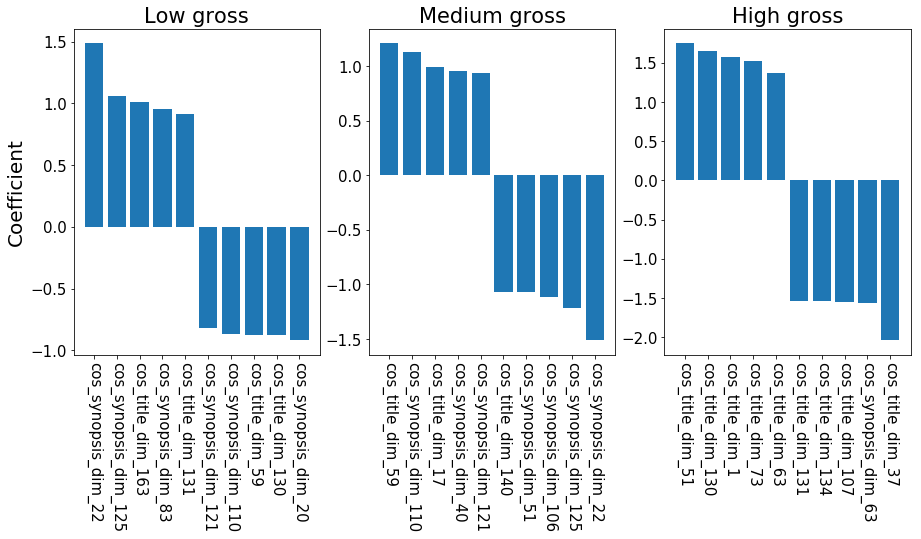

In [1325]:
plot_most_relevant_features(model_lr_1_tfidf, list(X_train.columns))

Positively associated with low grossing movies:

In [1374]:
dimensions[['en_label', 'tokenized']].iloc[[22,125,163, 83, 131]]

,en_label,tokenized
22,career,"[executive, management, professional, corporat..."
125,sport,"[sport, volleyball, basketball, fussball, hand..."
163,valuable,"[valuable, good_reputation, prestigious, recog..."
83,lifestyle,"[life, lifestyle, freedom]"
131,technical,"[technical, high_tech, industrial, mechanical,..."


Negatively associated with low grossing movies:

In [1373]:
dimensions[['en_label', 'tokenized']].iloc[[20, 130, 59, 110, 121]]

,en_label,tokenized
20,breakfast items,"[cheese, yoghurt, fat, oil, baguette, croissan..."
130,teaching,"[teaching, teach, learning, learn, course]"
59,fish,"[fish, blue]"
110,philharmonics,"[philharmonic, philharmonics, classical, classic]"
121,science,"[science, technology, physics, chemistry, eins..."


Positively associated with medium grossing movies:

In [1372]:
dimensions[['en_label', 'tokenized']].iloc[[59, 110, 17, 40, 121]]

,en_label,tokenized
59,fish,"[fish, blue]"
110,philharmonics,"[philharmonic, philharmonics, classical, classic]"
17,blue_collar,"[carpenter, plumber, trucker, janitor, mechanic]"
40,innovative,"[innovative, advanced, modern, progressive, av..."
121,science,"[science, technology, physics, chemistry, eins..."


Negatively associated with medium grossing movies:

In [1371]:
dimensions[['en_label', 'tokenized']].iloc[[22, 125, 106, 51, 140]]

,en_label,tokenized
22,career,"[executive, management, professional, corporat..."
125,sport,"[sport, volleyball, basketball, fussball, hand..."
106,new,"[new, fresh, all_new, brand_new, model]"
51,evaluating,"[evaluating, appraise, assess, calculate, clas..."
140,thejester,"[jester, lighten_up, great_time, play, jokes, ..."


Positively associated with high grossing movies:

In [1370]:
dimensions[['en_label', 'tokenized']].iloc[[51, 130, 1, 73, 63]]

,en_label,tokenized
51,evaluating,"[evaluating, appraise, assess, calculate, clas..."
130,teaching,"[teaching, teach, learning, learn, course]"
1,added_words,"[sharing, smart, freedom, safety, comfort]"
73,winner,"[winner, champ, first, award, medal, champion,..."
63,friendship,"[friendship, friends, friend, buddy, buddies, ..."


Negatively associated with high grossing movies:

In [1369]:
dimensions[['en_label', 'tokenized']].iloc[[37, 63, 107, 134, 131]]

,en_label,tokenized
37,design,"[design, modern, sleek, slender, form, idea, l..."
63,friendship,"[friendship, friends, friend, buddy, buddies, ..."
107,diligent,"[conscientious, prompt, dutiful, punctual, har..."
134,thecarer,"[neighbor, neighbor, help, helper, selfishness..."
131,technical,"[technical, high_tech, industrial, mechanical,..."


## Let's try running the model for Comedy.

In [1357]:
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset_for_genre_classification(no_blockbuster, emb, genre = 'Comedy', var = 'gross_bracket', tfidf = False, whole = False)

In [1358]:
model_lr = train_model('lr', X_train, y_train, 1)

In [1378]:
evaluate_model(model_lr, X_test, y_test)

accuracy : 0.6229508196721312
             precision    recall  f1-score   support

          0       0.67      0.85      0.75        82
          1       0.42      0.17      0.24        29
          2       0.17      0.09      0.12        11

avg / total       0.57      0.62      0.57       122

[[70  7  5]
 [24  5  0]
 [10  0  1]]


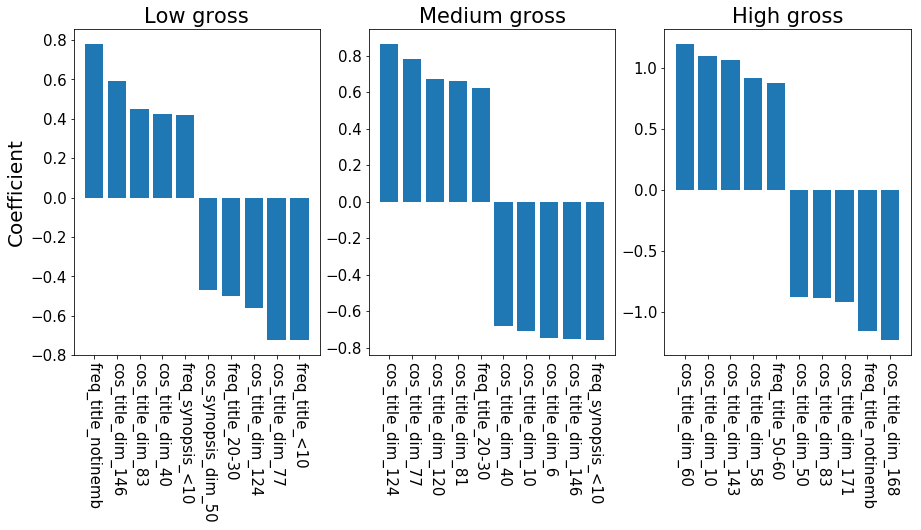

In [1359]:
plot_most_relevant_features(model_lr, list(X_train.columns))

Positive association with high grossing:

In [1368]:
dimensions[['en_label', 'tokenized']].iloc[[60, 10, 143, 58]]

,en_label,tokenized
60,flowers,"[rose, carnation, tulip, daisy, sunflower, daf..."
10,bad,[bad]
143,theruler,"[ruler, power, prosperous, successful, family,..."
58,female,"[female, woman, girl, sister, she, her, hers, ..."


Positive association with low grossing:

In [1367]:
dimensions[['en_label', 'tokenized']].iloc[[146, 83, 40]]

,en_label,tokenized
146,NaN,"[old, traditional, ancestral, hereditary, brou..."
83,lifestyle,"[life, lifestyle, freedom]"
40,innovative,"[innovative, advanced, modern, progressive, av..."


# Conclusion

* Word rank of title/synopsis doesn't seem to be correlated that much with success of a movie.
* Our LR model says that the similarity of the synopsis to the career dimension is associated with high probability of beign a low grosser. On the other side, films with titles semantically linked to evaluating and teaching have high probability of being a high grosser.
* From our sample for Comedy, we see that flowers, bad, female correlate with high gross, while traditional, lifestyle, innovative correlate with low gross.